# Testing this example with <a href="https://github.com/fastmachinelearning/hls4ml" class="external">HLS4ML</a>
##### Copyright 2020 The TensorFlow Authors. Notebook modified by <a href="https://github.com/ThGkasios" class="external">ThGkasios</a>
Contents (*clickable links work only in Jupyter*):
- <a href="#Setup">Setup</a>
- <a href="#Import-the-mini-Speech-Commands-Dataset">Import the Dataset</a>
- <a href="#Convert-waveforms-to-spectrograms">Convert waveforms to spectrograms</a>
- <a href="#Build-and-train-the-model">Build and train the model</a>
- <a href="#Processing-the-model-for-hls4ml">Processing the model for hls4ml</a>
- <a href="#HLS4ML-Configuration-&-Compilation">HLS4ML Configuration and Compilation</a>
- <a href="#Resulting-Statistics">Resulting Statistics</a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Source: Tensorflow Example
### Simple audio recognition: Recognizing keywords

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/simple_audio">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/simple_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to preprocess audio files in the WAV format and build and train a basic <a href="https://en.wikipedia.org/wiki/Speech_recognition" class="external">automatic speech recognition</a> (ASR) model for recognizing eight different words. You will use a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) (<a href="https://arxiv.org/abs/1804.03209" class="external">Warden, 2018</a>), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".

Real-world speech and audio recognition <a href="https://ai.googleblog.com/search/label/Speech%20Recognition" class="external">systems</a> are complex. But, like [image classification with the MNIST dataset](../quickstart/beginner.ipynb), this tutorial should give you a basic understanding of the techniques involved.

## Setup

In [2]:
import os
import pathlib
import time

import matplotlib.pyplot as plt
import plotting
import numpy as np
import seaborn as sns # Data Visualization
import tensorflow as tf

import hls4ml
import math

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2022-07-22 05:48:11.423401: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-22 05:48:11.423427: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/simplehls/anaconda3/lib/python3.9/site-packages/hls4ml/converters/__init__.py:16: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


## Import the mini Speech Commands Dataset

To save time with data loading, you will be working with a smaller version of the Speech Commands dataset. The [original dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) consists of over 105,000 audio files in the <a href="https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf" class="external">WAV (Waveform) audio file format</a> of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

In [3]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file('mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True, cache_dir='.', cache_subdir='data')

The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['up' 'stop' 'go' 'right' 'no' 'yes' 'left' 'down']


Extract the audio clips into a list called `filenames`, and shuffle it:

In [5]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:', len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/left/215699ff_nohash_1.wav', shape=(), dtype=string)


2022-07-22 05:48:14.667724: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-22 05:48:14.667750: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-22 05:48:14.667763: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (simplehls-VirtualBox): /proc/driver/nvidia/version does not exist
2022-07-22 05:48:14.668605: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Split `filenames` into training, validation and test sets using a 80:10:10 ratio, respectively:

In [6]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


## Read the audio files and their labels

In this section you will preprocess the dataset, creating decoded tensors for the waveforms and the corresponding labels. Note that:

- Each WAV file contains time-series data with a set number of samples per second.
- Each sample represents the <a href="https://en.wikipedia.org/wiki/Amplitude" class="external">amplitude</a> of the audio signal at that specific time.
- In a <a href="https://en.wikipedia.org/wiki/Audio_bit_depth" class="external">16-bit</a> system, like the WAV files in the mini Speech Commands dataset, the amplitude values range from -32,768 to 32,767.
- The <a href="https://en.wikipedia.org/wiki/Sampling_(signal_processing)#Audio_sampling" class="external">sample rate</a> for this dataset is 16kHz.

The shape of the tensor returned by `tf.audio.decode_wav` is `[samples, channels]`, where `channels` is `1` for mono or `2` for stereo. The mini Speech Commands dataset only contains mono recordings. 

In [7]:
test_file = tf.io.read_file('data/mini_speech_commands/down/0a9f9af7_nohash_0.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([13654, 1])

Now, let's define a function that preprocesses the dataset's raw WAV audio files into audio tensors:

In [8]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

Define a function that creates labels using the parent directories for each file:

- Split the file paths into `tf.RaggedTensor`s (tensors with ragged dimensions—with slices that may have different lengths).

In [9]:
def get_label(file_path):
  parts = tf.strings.split(input=file_path, sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

Define another helper function—`get_waveform_and_label`—that puts it all together:

- The input is the WAV audio filename.
- The output is a tuple containing the audio and label tensors ready for supervised learning.

In [10]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

Build the training set to extract the audio-label pairs:

- Create a `tf.data.Dataset` with `Dataset.from_tensor_slices` and `Dataset.map`, using `get_waveform_and_label` defined earlier.

You'll build the validation and test sets using a similar procedure later on.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(map_func=get_waveform_and_label, num_parallel_calls=AUTOTUNE)

Let's plot a few audio waveforms:

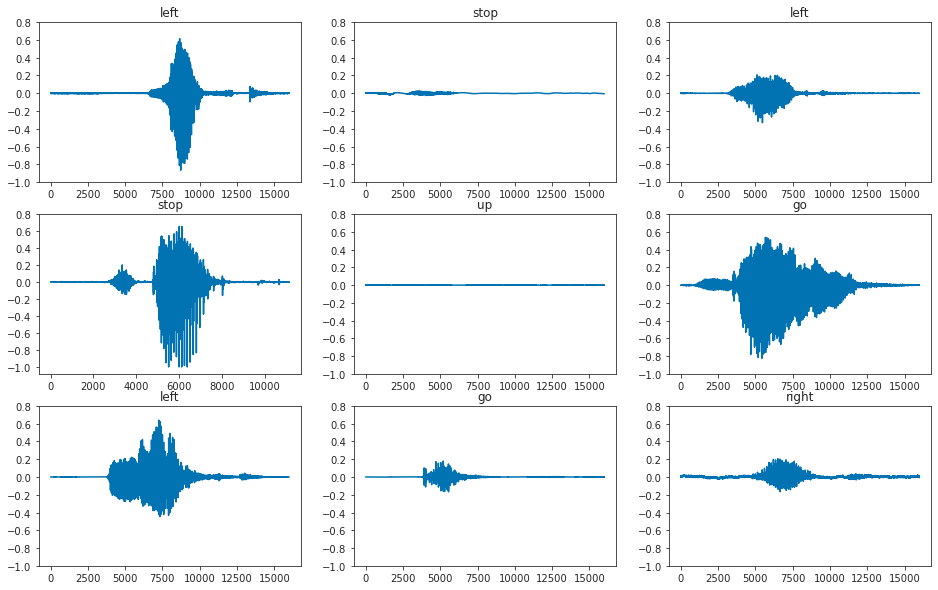

In [12]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 10))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  ax = axes[i // cols][i % cols]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1., 1., 0.2))
  ax.set_title(label.numpy().decode('utf-8'))

plt.show()

# Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the <a href="https://en.wikipedia.org/wiki/Short-time_Fourier_transform" class="external">short-time Fourier transform (STFT)</a> to convert the waveforms to as <a href="https://en.wikipedia.org/wiki/Spectrogram" clas="external">spectrograms</a>, which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to <a href="https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe" class="external">this Coursera video</a> on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [13]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  waveform = waveform[:16000]
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [14]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [15]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec, shading='nearest')

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

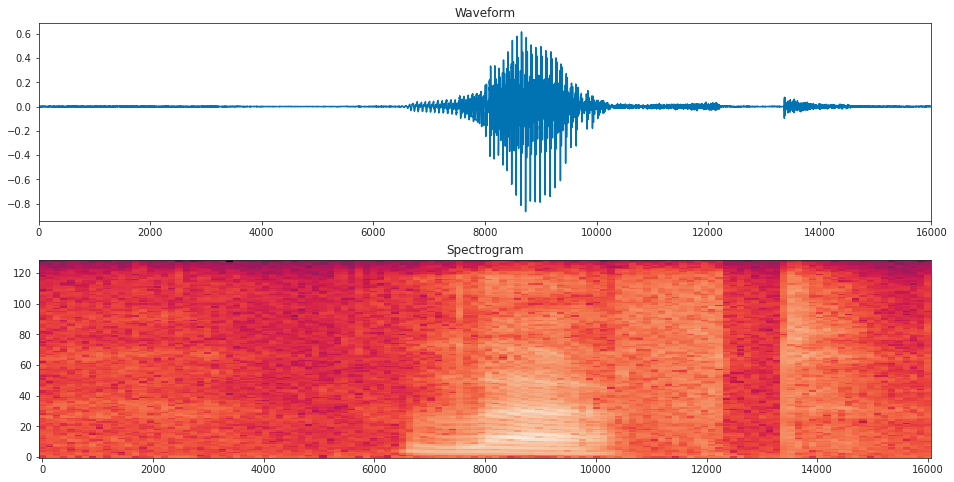

In [16]:
fig, axes = plt.subplots(2, figsize=(16, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Now, define a function that transforms the waveform dataset into spectrograms and their corresponding labels as integer IDs:

In [17]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

Map `get_spectrogram_and_label_id` across the dataset's elements with `Dataset.map`:

In [18]:
spectrogram_ds = waveform_ds.map(map_func=get_spectrogram_and_label_id,num_parallel_calls=AUTOTUNE)

Examine the spectrograms for different examples of the dataset:

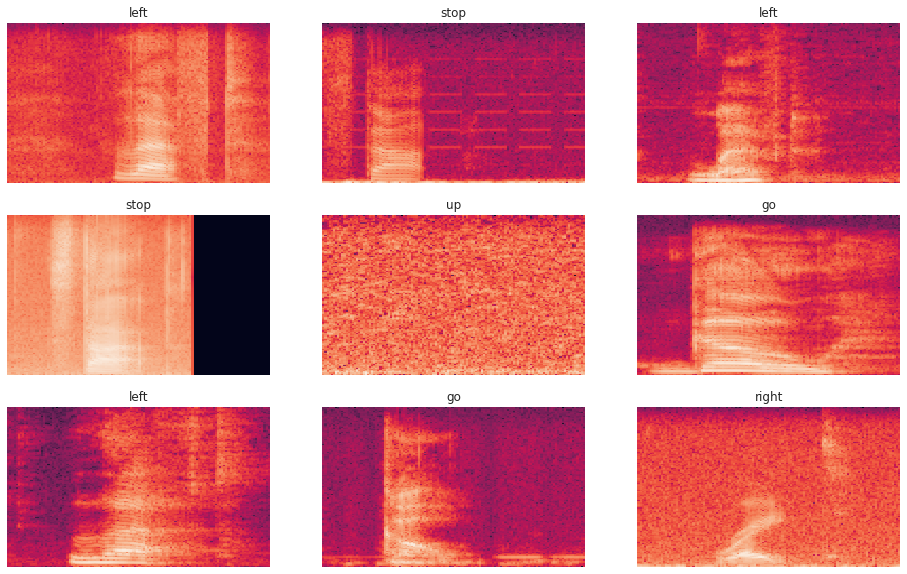

In [19]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  ax = axes[i // cols][i % cols]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

# Build and train the model

Repeat the training set preprocessing on the validation and test sets:

In [20]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(map_func=get_waveform_and_label,num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(map_func=get_spectrogram_and_label_id,num_parallel_calls=AUTOTUNE)
  return output_ds

Batch the training and validation sets for model training, and add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [21]:
batch_size = 64
train_ds = spectrogram_ds.batch(batch_size).prefetch(AUTOTUNE)
val_ds = preprocess_dataset(val_files).batch(batch_size).prefetch(AUTOTUNE)

## Model Settings

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your <a href="https://www.tensorflow.org/api_docs/python/tf/keras/Sequential" class="external">`tf.keras.Sequential`</a> model will use the following Keras preprocessing layers:
- <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing" class="external">`tf.keras.layers.Resizing`</a> downsamples the input to enable the model to train faster.
- <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization" class="external">`tf.keras.layers.Normalization`</a> normalizes each pixel in the image based on its mean and standard deviation.

**As of lately, hls4ml-0.5.x does not support these layers.** For the purposes of this implementation, `Resizing` is omitted, and `Normalization` is replaced by <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization" class="external">`tf.keras.layers.BatchNormalization`</a>, which is supported by hls4ml

In [22]:
input_shape = None
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

Input shape: (124, 129, 1)


The parameters below accommodate different strategies for this design
- The **fast** strategy can yield quick compilation time and quick results, but requires lowering the number of weights to about 1/60th of the original model, which significantly lowers the accuracy of the model, which limits its applicability and requires additional training to elevate accuracy above loss.
  - This is useful for testing purposes
- The **slow** strategy achieves compiling the original model accurately, which means, but it takes a longer time to build the model using Vivado, and requires additional resources (such as more RAM on the computer)
  - This won't work currently due to its enormous requirement
- The **absolute** strategy attempts to run the model through the tool by any means necessary, primarily by cutting the keras model size and then raising the reuse factor for the conversion

In [23]:
hw_strategies = {
    # Minimized Latency
    'fast' : {
        'conv2d' : 4,
        'conv2d_1' : 8,
        'dense' : 16,
        'Strategy' : 'Latency',
        'ConvReuseFactor' : 1,
        'DenseReuseFactor' : 1,
        'epochs' : 10,
    },
    # Original model values
    'slow' : {
        'conv2d' : 32,
        'conv2d_1' : 64,
        'dense' : 128,
        'Strategy' : 'Resource',
        'ConvReuseFactor' : 9,
        'DenseReuseFactor' : 8,
        'epochs' : 10,
    },
    'absolute' : {
        'conv2d' : 1,
        'conv2d_1' : None, #Not used
        'dense' : 12,
        'Strategy' : 'Resource',
        'ConvReuseFactor' : 9,
        'DenseReuseFactor' : 1000,
        'epochs' : 5000,
    }
}
hw_strat = 'absolute'

Creating the `Sequential` model.

In [24]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.BatchNormalization(),
    layers.Conv2D(hw_strategies[hw_strat]['conv2d'], 3, activation='relu'),
    #layers.Conv2D(hw_strategies[hw_strat]['conv2d_1'], 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(hw_strategies[hw_strat]['dense'], activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 124, 129, 1)      4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 122, 127, 1)       10        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 61, 63, 1)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 61, 63, 1)         0         
                                                                 
 flatten (Flatten)           (None, 3843)              0         
                                                                 
 dense (Dense)               (None, 12)                4

Configure the Keras model with the Adam optimizer and the cross-entropy loss:
- <a href="https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam" class="external">`tf.keras.optimizers.Adam`</a>: "Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments."
- <a href="https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy" class="external">`tf.keras.losses.SparseCategoricalCrossentropy`</a> works with labels being represented as integers, instead of "one-hot" representation.

In [25]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

history = model.fit(
    train_ds, validation_data=val_ds,
    epochs=hw_strategies[hw_strat]['epochs'],
    callbacks=None, verbose=1
)

Epoch 1/5000
100/100 [==============================] - 33s 329ms/step - loss: 2.1268 - accuracy: 0.1467 - val_loss: 1.9914 - val_accuracy: 0.1800
Epoch 2/5000
100/100 [==============================] - 32s 317ms/step - loss: 2.0274 - accuracy: 0.1823 - val_loss: 1.9365 - val_accuracy: 0.2575
Epoch 3/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.9519 - accuracy: 0.2255 - val_loss: 1.8466 - val_accuracy: 0.2912
Epoch 4/5000
100/100 [==============================] - 33s 326ms/step - loss: 1.9073 - accuracy: 0.2512 - val_loss: 1.7997 - val_accuracy: 0.3537
Epoch 5/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.8774 - accuracy: 0.2573 - val_loss: 1.8042 - val_accuracy: 0.3275
Epoch 6/5000
100/100 [==============================] - 32s 314ms/step - loss: 1.8625 - accuracy: 0.2620 - val_loss: 1.7470 - val_accuracy: 0.3512
Epoch 7/5000
100/100 [==============================] - 32s 319ms/step - loss: 1.8406 - accuracy: 0.2634 - val_loss: 1

100/100 [==============================] - 32s 315ms/step - loss: 1.3263 - accuracy: 0.4794 - val_loss: 1.5768 - val_accuracy: 0.5575
Epoch 112/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.3437 - accuracy: 0.4702 - val_loss: 1.5680 - val_accuracy: 0.5587
Epoch 113/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.3394 - accuracy: 0.4764 - val_loss: 1.5158 - val_accuracy: 0.5537
Epoch 114/5000
100/100 [==============================] - 32s 320ms/step - loss: 1.3432 - accuracy: 0.4769 - val_loss: 1.5596 - val_accuracy: 0.5575
Epoch 115/5000
100/100 [==============================] - 32s 319ms/step - loss: 1.3357 - accuracy: 0.4784 - val_loss: 1.5454 - val_accuracy: 0.5512
Epoch 116/5000
100/100 [==============================] - 31s 312ms/step - loss: 1.3223 - accuracy: 0.4808 - val_loss: 1.5355 - val_accuracy: 0.5575
Epoch 117/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.3086 - accuracy: 0.4814 - val_loss: 1.

100/100 [==============================] - 31s 311ms/step - loss: 1.2970 - accuracy: 0.4923 - val_loss: 1.6951 - val_accuracy: 0.5562
Epoch 167/5000
100/100 [==============================] - 32s 320ms/step - loss: 1.2907 - accuracy: 0.4958 - val_loss: 1.6827 - val_accuracy: 0.5500
Epoch 168/5000
100/100 [==============================] - 31s 311ms/step - loss: 1.2714 - accuracy: 0.5070 - val_loss: 1.7287 - val_accuracy: 0.5525
Epoch 169/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.2932 - accuracy: 0.4911 - val_loss: 1.7097 - val_accuracy: 0.5587
Epoch 170/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.2714 - accuracy: 0.4975 - val_loss: 1.7486 - val_accuracy: 0.5675
Epoch 171/5000
100/100 [==============================] - 31s 310ms/step - loss: 1.2754 - accuracy: 0.5034 - val_loss: 1.7297 - val_accuracy: 0.5550
Epoch 172/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.2697 - accuracy: 0.5022 - val_loss: 1.

100/100 [==============================] - 31s 312ms/step - loss: 1.2357 - accuracy: 0.5194 - val_loss: 1.7983 - val_accuracy: 0.5688
Epoch 222/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.2495 - accuracy: 0.5144 - val_loss: 1.7925 - val_accuracy: 0.5612
Epoch 223/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.2432 - accuracy: 0.5175 - val_loss: 1.7951 - val_accuracy: 0.5587
Epoch 224/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.2455 - accuracy: 0.5166 - val_loss: 1.8666 - val_accuracy: 0.5663
Epoch 225/5000
100/100 [==============================] - 32s 320ms/step - loss: 1.2330 - accuracy: 0.5133 - val_loss: 1.8354 - val_accuracy: 0.5750
Epoch 226/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.2351 - accuracy: 0.5161 - val_loss: 1.8341 - val_accuracy: 0.5650
Epoch 227/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.2608 - accuracy: 0.5075 - val_loss: 1.

100/100 [==============================] - 32s 315ms/step - loss: 1.2209 - accuracy: 0.5156 - val_loss: 1.9100 - val_accuracy: 0.5337
Epoch 277/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.2354 - accuracy: 0.5127 - val_loss: 1.9536 - val_accuracy: 0.5650
Epoch 278/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.2184 - accuracy: 0.5239 - val_loss: 1.9249 - val_accuracy: 0.5600
Epoch 279/5000
100/100 [==============================] - 31s 311ms/step - loss: 1.2132 - accuracy: 0.5225 - val_loss: 1.9374 - val_accuracy: 0.5437
Epoch 280/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.2178 - accuracy: 0.5242 - val_loss: 1.8760 - val_accuracy: 0.5325
Epoch 281/5000
100/100 [==============================] - 32s 319ms/step - loss: 1.2386 - accuracy: 0.5181 - val_loss: 1.8473 - val_accuracy: 0.5487
Epoch 282/5000
100/100 [==============================] - 32s 319ms/step - loss: 1.2247 - accuracy: 0.5186 - val_loss: 1.

100/100 [==============================] - 32s 322ms/step - loss: 1.1876 - accuracy: 0.5342 - val_loss: 1.9697 - val_accuracy: 0.5475
Epoch 332/5000
100/100 [==============================] - 32s 319ms/step - loss: 1.2094 - accuracy: 0.5233 - val_loss: 1.9660 - val_accuracy: 0.5462
Epoch 333/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.2136 - accuracy: 0.5213 - val_loss: 1.9467 - val_accuracy: 0.5462
Epoch 334/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.2039 - accuracy: 0.5250 - val_loss: 1.9796 - val_accuracy: 0.5738
Epoch 335/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.2010 - accuracy: 0.5292 - val_loss: 1.8884 - val_accuracy: 0.5312
Epoch 336/5000
100/100 [==============================] - 32s 319ms/step - loss: 1.2015 - accuracy: 0.5350 - val_loss: 1.9129 - val_accuracy: 0.5475
Epoch 337/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.1897 - accuracy: 0.5305 - val_loss: 2.

100/100 [==============================] - 32s 320ms/step - loss: 1.2010 - accuracy: 0.5358 - val_loss: 1.9854 - val_accuracy: 0.5288
Epoch 387/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.2227 - accuracy: 0.5167 - val_loss: 2.0421 - val_accuracy: 0.5537
Epoch 388/5000
100/100 [==============================] - 32s 320ms/step - loss: 1.2224 - accuracy: 0.5233 - val_loss: 2.0052 - val_accuracy: 0.5537
Epoch 389/5000
100/100 [==============================] - 32s 319ms/step - loss: 1.2131 - accuracy: 0.5272 - val_loss: 1.9967 - val_accuracy: 0.5500
Epoch 390/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.2117 - accuracy: 0.5297 - val_loss: 1.9727 - val_accuracy: 0.5400
Epoch 391/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.2018 - accuracy: 0.5266 - val_loss: 1.9854 - val_accuracy: 0.5600
Epoch 392/5000
100/100 [==============================] - 31s 312ms/step - loss: 1.2190 - accuracy: 0.5386 - val_loss: 1.

100/100 [==============================] - 33s 333ms/step - loss: 1.1677 - accuracy: 0.5348 - val_loss: 2.0414 - val_accuracy: 0.5475
Epoch 442/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.1854 - accuracy: 0.5430 - val_loss: 2.0094 - val_accuracy: 0.5462
Epoch 443/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.1758 - accuracy: 0.5358 - val_loss: 2.0686 - val_accuracy: 0.5675
Epoch 444/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.1745 - accuracy: 0.5412 - val_loss: 2.0337 - val_accuracy: 0.5587
Epoch 445/5000
100/100 [==============================] - 32s 320ms/step - loss: 1.1887 - accuracy: 0.5403 - val_loss: 1.9669 - val_accuracy: 0.5512
Epoch 446/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.2000 - accuracy: 0.5356 - val_loss: 1.9648 - val_accuracy: 0.5525
Epoch 447/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.1892 - accuracy: 0.5377 - val_loss: 1.

100/100 [==============================] - 32s 319ms/step - loss: 1.1610 - accuracy: 0.5381 - val_loss: 2.1105 - val_accuracy: 0.5587
Epoch 497/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.1641 - accuracy: 0.5491 - val_loss: 2.0651 - val_accuracy: 0.5500
Epoch 498/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.1715 - accuracy: 0.5414 - val_loss: 2.0841 - val_accuracy: 0.5675
Epoch 499/5000
100/100 [==============================] - 32s 319ms/step - loss: 1.1524 - accuracy: 0.5453 - val_loss: 2.1998 - val_accuracy: 0.5738
Epoch 500/5000
100/100 [==============================] - 32s 321ms/step - loss: 1.1491 - accuracy: 0.5417 - val_loss: 2.1348 - val_accuracy: 0.5525
Epoch 501/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.1698 - accuracy: 0.5433 - val_loss: 2.1542 - val_accuracy: 0.5475
Epoch 502/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.1729 - accuracy: 0.5419 - val_loss: 2.

100/100 [==============================] - 32s 317ms/step - loss: 1.1661 - accuracy: 0.5437 - val_loss: 2.0948 - val_accuracy: 0.5650
Epoch 552/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.1670 - accuracy: 0.5452 - val_loss: 2.1266 - val_accuracy: 0.5387
Epoch 553/5000
100/100 [==============================] - 32s 319ms/step - loss: 1.1825 - accuracy: 0.5423 - val_loss: 2.0447 - val_accuracy: 0.5500
Epoch 554/5000
100/100 [==============================] - 32s 314ms/step - loss: 1.1783 - accuracy: 0.5386 - val_loss: 2.0695 - val_accuracy: 0.5337
Epoch 555/5000
100/100 [==============================] - 32s 319ms/step - loss: 1.1604 - accuracy: 0.5420 - val_loss: 2.0668 - val_accuracy: 0.5350
Epoch 556/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.1736 - accuracy: 0.5364 - val_loss: 2.0790 - val_accuracy: 0.5587
Epoch 557/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.1482 - accuracy: 0.5491 - val_loss: 2.

100/100 [==============================] - 32s 318ms/step - loss: 1.1718 - accuracy: 0.5430 - val_loss: 2.1565 - val_accuracy: 0.5587
Epoch 607/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.1552 - accuracy: 0.5408 - val_loss: 2.1258 - val_accuracy: 0.5600
Epoch 608/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.1811 - accuracy: 0.5408 - val_loss: 2.1504 - val_accuracy: 0.5500
Epoch 609/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.1575 - accuracy: 0.5472 - val_loss: 2.1563 - val_accuracy: 0.5600
Epoch 610/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.1450 - accuracy: 0.5516 - val_loss: 2.1366 - val_accuracy: 0.5587
Epoch 611/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.1473 - accuracy: 0.5525 - val_loss: 2.1681 - val_accuracy: 0.5525
Epoch 612/5000
100/100 [==============================] - 32s 321ms/step - loss: 1.1670 - accuracy: 0.5447 - val_loss: 2.

100/100 [==============================] - 31s 313ms/step - loss: 1.1472 - accuracy: 0.5433 - val_loss: 2.2541 - val_accuracy: 0.5375
Epoch 662/5000
100/100 [==============================] - 32s 319ms/step - loss: 1.1483 - accuracy: 0.5545 - val_loss: 2.2635 - val_accuracy: 0.5525
Epoch 663/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.1673 - accuracy: 0.5497 - val_loss: 2.1838 - val_accuracy: 0.5475
Epoch 664/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.1451 - accuracy: 0.5550 - val_loss: 2.2793 - val_accuracy: 0.5437
Epoch 665/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.1534 - accuracy: 0.5539 - val_loss: 2.2132 - val_accuracy: 0.5537
Epoch 666/5000
100/100 [==============================] - 32s 321ms/step - loss: 1.1514 - accuracy: 0.5505 - val_loss: 2.1876 - val_accuracy: 0.5362
Epoch 667/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.1370 - accuracy: 0.5489 - val_loss: 2.

100/100 [==============================] - 32s 319ms/step - loss: 1.1799 - accuracy: 0.5430 - val_loss: 2.2263 - val_accuracy: 0.5462
Epoch 717/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.1393 - accuracy: 0.5508 - val_loss: 2.2705 - val_accuracy: 0.5575
Epoch 718/5000
100/100 [==============================] - 32s 314ms/step - loss: 1.1411 - accuracy: 0.5505 - val_loss: 2.1984 - val_accuracy: 0.5550
Epoch 719/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.1388 - accuracy: 0.5509 - val_loss: 2.1442 - val_accuracy: 0.5475
Epoch 720/5000
100/100 [==============================] - 31s 311ms/step - loss: 1.1290 - accuracy: 0.5605 - val_loss: 2.1776 - val_accuracy: 0.5612
Epoch 721/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.1327 - accuracy: 0.5527 - val_loss: 2.1232 - val_accuracy: 0.5575
Epoch 722/5000
100/100 [==============================] - 32s 320ms/step - loss: 1.1335 - accuracy: 0.5558 - val_loss: 2.

100/100 [==============================] - 31s 311ms/step - loss: 1.1744 - accuracy: 0.5456 - val_loss: 2.1860 - val_accuracy: 0.5387
Epoch 772/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.1458 - accuracy: 0.5489 - val_loss: 2.1961 - val_accuracy: 0.5412
Epoch 773/5000
100/100 [==============================] - 31s 310ms/step - loss: 1.1321 - accuracy: 0.5572 - val_loss: 2.2162 - val_accuracy: 0.5462
Epoch 774/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.1429 - accuracy: 0.5439 - val_loss: 2.1947 - val_accuracy: 0.5487
Epoch 775/5000
100/100 [==============================] - 32s 314ms/step - loss: 1.1629 - accuracy: 0.5502 - val_loss: 2.1663 - val_accuracy: 0.5425
Epoch 776/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.1644 - accuracy: 0.5434 - val_loss: 2.1996 - val_accuracy: 0.5512
Epoch 777/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.1689 - accuracy: 0.5502 - val_loss: 2.

100/100 [==============================] - 32s 315ms/step - loss: 1.1323 - accuracy: 0.5489 - val_loss: 2.2043 - val_accuracy: 0.5375
Epoch 827/5000
100/100 [==============================] - 31s 312ms/step - loss: 1.1293 - accuracy: 0.5594 - val_loss: 2.2827 - val_accuracy: 0.5562
Epoch 828/5000
100/100 [==============================] - 32s 319ms/step - loss: 1.1195 - accuracy: 0.5581 - val_loss: 2.2654 - val_accuracy: 0.5562
Epoch 829/5000
100/100 [==============================] - 31s 312ms/step - loss: 1.1351 - accuracy: 0.5616 - val_loss: 2.1789 - val_accuracy: 0.5550
Epoch 830/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.1562 - accuracy: 0.5491 - val_loss: 2.1596 - val_accuracy: 0.5537
Epoch 831/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.1227 - accuracy: 0.5553 - val_loss: 2.2239 - val_accuracy: 0.5462
Epoch 832/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.1562 - accuracy: 0.5427 - val_loss: 2.

100/100 [==============================] - 32s 314ms/step - loss: 1.1384 - accuracy: 0.5519 - val_loss: 2.2516 - val_accuracy: 0.5500
Epoch 882/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.1251 - accuracy: 0.5591 - val_loss: 2.1484 - val_accuracy: 0.5325
Epoch 883/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.1455 - accuracy: 0.5483 - val_loss: 2.1577 - val_accuracy: 0.5350
Epoch 884/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.1293 - accuracy: 0.5580 - val_loss: 2.2013 - val_accuracy: 0.5425
Epoch 885/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.1135 - accuracy: 0.5587 - val_loss: 2.2190 - val_accuracy: 0.5550
Epoch 886/5000
100/100 [==============================] - 32s 314ms/step - loss: 1.1137 - accuracy: 0.5612 - val_loss: 2.2358 - val_accuracy: 0.5525
Epoch 887/5000
100/100 [==============================] - 32s 314ms/step - loss: 1.1433 - accuracy: 0.5625 - val_loss: 2.

100/100 [==============================] - 32s 319ms/step - loss: 1.1653 - accuracy: 0.5455 - val_loss: 2.0978 - val_accuracy: 0.5537
Epoch 937/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.1271 - accuracy: 0.5566 - val_loss: 2.1537 - val_accuracy: 0.5400
Epoch 938/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.1443 - accuracy: 0.5553 - val_loss: 2.1934 - val_accuracy: 0.5550
Epoch 939/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.1505 - accuracy: 0.5552 - val_loss: 2.1468 - val_accuracy: 0.5562
Epoch 940/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.1044 - accuracy: 0.5653 - val_loss: 2.2164 - val_accuracy: 0.5500
Epoch 941/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.1100 - accuracy: 0.5586 - val_loss: 2.1825 - val_accuracy: 0.5462
Epoch 942/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.1234 - accuracy: 0.5620 - val_loss: 2.

100/100 [==============================] - 32s 320ms/step - loss: 1.1298 - accuracy: 0.5581 - val_loss: 2.2404 - val_accuracy: 0.5525
Epoch 992/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.1206 - accuracy: 0.5533 - val_loss: 2.2929 - val_accuracy: 0.5700
Epoch 993/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.1158 - accuracy: 0.5650 - val_loss: 2.2341 - val_accuracy: 0.5475
Epoch 994/5000
100/100 [==============================] - 32s 314ms/step - loss: 1.1340 - accuracy: 0.5689 - val_loss: 2.1995 - val_accuracy: 0.5512
Epoch 995/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.1315 - accuracy: 0.5597 - val_loss: 2.1876 - val_accuracy: 0.5525
Epoch 996/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.1223 - accuracy: 0.5594 - val_loss: 2.1773 - val_accuracy: 0.5475
Epoch 997/5000
100/100 [==============================] - 32s 319ms/step - loss: 1.1335 - accuracy: 0.5489 - val_loss: 2.

Epoch 1046/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.1259 - accuracy: 0.5581 - val_loss: 2.2458 - val_accuracy: 0.5512
Epoch 1047/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.1234 - accuracy: 0.5578 - val_loss: 2.2433 - val_accuracy: 0.5575
Epoch 1048/5000
100/100 [==============================] - 31s 311ms/step - loss: 1.1383 - accuracy: 0.5517 - val_loss: 2.2566 - val_accuracy: 0.5550
Epoch 1049/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.1081 - accuracy: 0.5578 - val_loss: 2.2975 - val_accuracy: 0.5562
Epoch 1050/5000
100/100 [==============================] - 32s 320ms/step - loss: 1.1408 - accuracy: 0.5491 - val_loss: 2.3034 - val_accuracy: 0.5437
Epoch 1051/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.1205 - accuracy: 0.5592 - val_loss: 2.2815 - val_accuracy: 0.5562
Epoch 1052/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.1361 - accuracy:

Epoch 1155/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.1263 - accuracy: 0.5633 - val_loss: 2.2161 - val_accuracy: 0.5550
Epoch 1156/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0896 - accuracy: 0.5698 - val_loss: 2.2129 - val_accuracy: 0.5525
Epoch 1157/5000
100/100 [==============================] - 32s 322ms/step - loss: 1.1325 - accuracy: 0.5559 - val_loss: 2.2190 - val_accuracy: 0.5500
Epoch 1158/5000
100/100 [==============================] - 32s 314ms/step - loss: 1.1341 - accuracy: 0.5562 - val_loss: 2.2073 - val_accuracy: 0.5500
Epoch 1159/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.1278 - accuracy: 0.5583 - val_loss: 2.2333 - val_accuracy: 0.5550
Epoch 1160/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.1256 - accuracy: 0.5648 - val_loss: 2.1903 - val_accuracy: 0.5525
Epoch 1161/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.1210 - accuracy:

Epoch 1264/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.1340 - accuracy: 0.5597 - val_loss: 2.2740 - val_accuracy: 0.5450
Epoch 1265/5000
100/100 [==============================] - 32s 319ms/step - loss: 1.0976 - accuracy: 0.5611 - val_loss: 2.3717 - val_accuracy: 0.5500
Epoch 1266/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.1377 - accuracy: 0.5658 - val_loss: 2.3429 - val_accuracy: 0.5475
Epoch 1267/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.1271 - accuracy: 0.5627 - val_loss: 2.3202 - val_accuracy: 0.5537
Epoch 1268/5000
100/100 [==============================] - 32s 314ms/step - loss: 1.1020 - accuracy: 0.5708 - val_loss: 2.3382 - val_accuracy: 0.5462
Epoch 1269/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.1141 - accuracy: 0.5691 - val_loss: 2.3116 - val_accuracy: 0.5575
Epoch 1270/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.1275 - accuracy:

Epoch 1373/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.1151 - accuracy: 0.5692 - val_loss: 2.3166 - val_accuracy: 0.5412
Epoch 1374/5000
100/100 [==============================] - 32s 320ms/step - loss: 1.0888 - accuracy: 0.5728 - val_loss: 2.3482 - val_accuracy: 0.5487
Epoch 1375/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.1010 - accuracy: 0.5703 - val_loss: 2.3902 - val_accuracy: 0.5500
Epoch 1376/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0941 - accuracy: 0.5722 - val_loss: 2.4134 - val_accuracy: 0.5550
Epoch 1377/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.1147 - accuracy: 0.5664 - val_loss: 2.3514 - val_accuracy: 0.5487
Epoch 1378/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.1216 - accuracy: 0.5691 - val_loss: 2.4026 - val_accuracy: 0.5487
Epoch 1379/5000
100/100 [==============================] - 31s 312ms/step - loss: 1.1107 - accuracy:

Epoch 1482/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.1102 - accuracy: 0.5622 - val_loss: 2.3923 - val_accuracy: 0.5562
Epoch 1483/5000
100/100 [==============================] - 32s 314ms/step - loss: 1.1266 - accuracy: 0.5633 - val_loss: 2.4614 - val_accuracy: 0.5562
Epoch 1484/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0768 - accuracy: 0.5784 - val_loss: 2.4963 - val_accuracy: 0.5475
Epoch 1485/5000
100/100 [==============================] - 31s 312ms/step - loss: 1.1209 - accuracy: 0.5567 - val_loss: 2.3982 - val_accuracy: 0.5387
Epoch 1486/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.0733 - accuracy: 0.5816 - val_loss: 2.4754 - val_accuracy: 0.5562
Epoch 1487/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.1081 - accuracy: 0.5623 - val_loss: 2.4863 - val_accuracy: 0.5412
Epoch 1488/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.0889 - accuracy:

Epoch 1591/5000
100/100 [==============================] - 31s 312ms/step - loss: 1.1054 - accuracy: 0.5752 - val_loss: 2.4002 - val_accuracy: 0.5587
Epoch 1592/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0803 - accuracy: 0.5814 - val_loss: 2.4761 - val_accuracy: 0.5663
Epoch 1593/5000
100/100 [==============================] - 31s 312ms/step - loss: 1.1061 - accuracy: 0.5628 - val_loss: 2.4450 - val_accuracy: 0.5487
Epoch 1594/5000
100/100 [==============================] - 32s 319ms/step - loss: 1.1061 - accuracy: 0.5711 - val_loss: 2.4267 - val_accuracy: 0.5750
Epoch 1595/5000
100/100 [==============================] - 32s 321ms/step - loss: 1.0809 - accuracy: 0.5738 - val_loss: 2.4151 - val_accuracy: 0.5575
Epoch 1596/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0974 - accuracy: 0.5673 - val_loss: 2.4300 - val_accuracy: 0.5575
Epoch 1597/5000
100/100 [==============================] - 32s 319ms/step - loss: 1.1026 - accuracy:

Epoch 1700/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.1108 - accuracy: 0.5673 - val_loss: 2.4781 - val_accuracy: 0.5562
Epoch 1701/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.0748 - accuracy: 0.5772 - val_loss: 2.4810 - val_accuracy: 0.5400
Epoch 1702/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.0957 - accuracy: 0.5658 - val_loss: 2.4395 - val_accuracy: 0.5437
Epoch 1703/5000
100/100 [==============================] - 31s 312ms/step - loss: 1.0951 - accuracy: 0.5753 - val_loss: 2.4777 - val_accuracy: 0.5537
Epoch 1704/5000
100/100 [==============================] - 32s 314ms/step - loss: 1.0939 - accuracy: 0.5681 - val_loss: 2.4455 - val_accuracy: 0.5487
Epoch 1705/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.0949 - accuracy: 0.5706 - val_loss: 2.4332 - val_accuracy: 0.5437
Epoch 1706/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.1045 - accuracy:

Epoch 1809/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.0876 - accuracy: 0.5741 - val_loss: 2.3383 - val_accuracy: 0.5575
Epoch 1810/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.1140 - accuracy: 0.5558 - val_loss: 2.3315 - val_accuracy: 0.5650
Epoch 1811/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.0952 - accuracy: 0.5673 - val_loss: 2.3211 - val_accuracy: 0.5537
Epoch 1812/5000
100/100 [==============================] - 31s 311ms/step - loss: 1.0935 - accuracy: 0.5759 - val_loss: 2.3343 - val_accuracy: 0.5663
Epoch 1813/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.1111 - accuracy: 0.5623 - val_loss: 2.3033 - val_accuracy: 0.5688
Epoch 1814/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.1121 - accuracy: 0.5636 - val_loss: 2.2605 - val_accuracy: 0.5587
Epoch 1815/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0974 - accuracy:

Epoch 1918/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0838 - accuracy: 0.5838 - val_loss: 2.4000 - val_accuracy: 0.5537
Epoch 1919/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.0866 - accuracy: 0.5713 - val_loss: 2.3903 - val_accuracy: 0.5387
Epoch 1920/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.0887 - accuracy: 0.5780 - val_loss: 2.4177 - val_accuracy: 0.5500
Epoch 1921/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0804 - accuracy: 0.5686 - val_loss: 2.4554 - val_accuracy: 0.5600
Epoch 1922/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0735 - accuracy: 0.5770 - val_loss: 2.3986 - val_accuracy: 0.5387
Epoch 1923/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.1091 - accuracy: 0.5661 - val_loss: 2.4535 - val_accuracy: 0.5450
Epoch 1924/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.1057 - accuracy:

Epoch 2027/5000
100/100 [==============================] - 31s 310ms/step - loss: 1.0962 - accuracy: 0.5708 - val_loss: 2.4764 - val_accuracy: 0.5462
Epoch 2028/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.1087 - accuracy: 0.5689 - val_loss: 2.4969 - val_accuracy: 0.5325
Epoch 2029/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0830 - accuracy: 0.5733 - val_loss: 2.4979 - val_accuracy: 0.5412
Epoch 2030/5000
100/100 [==============================] - 31s 311ms/step - loss: 1.0896 - accuracy: 0.5664 - val_loss: 2.4867 - val_accuracy: 0.5512
Epoch 2031/5000
100/100 [==============================] - 31s 312ms/step - loss: 1.0781 - accuracy: 0.5738 - val_loss: 2.4937 - val_accuracy: 0.5387
Epoch 2032/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.0983 - accuracy: 0.5698 - val_loss: 2.4986 - val_accuracy: 0.5487
Epoch 2033/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0983 - accuracy:

Epoch 2136/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.0950 - accuracy: 0.5759 - val_loss: 2.3507 - val_accuracy: 0.5437
Epoch 2137/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.0805 - accuracy: 0.5797 - val_loss: 2.3686 - val_accuracy: 0.5475
Epoch 2138/5000
100/100 [==============================] - 31s 312ms/step - loss: 1.0678 - accuracy: 0.5792 - val_loss: 2.3391 - val_accuracy: 0.5450
Epoch 2139/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0680 - accuracy: 0.5813 - val_loss: 2.3566 - val_accuracy: 0.5400
Epoch 2140/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.0914 - accuracy: 0.5708 - val_loss: 2.3335 - val_accuracy: 0.5562
Epoch 2141/5000
100/100 [==============================] - 34s 343ms/step - loss: 1.0748 - accuracy: 0.5750 - val_loss: 2.3340 - val_accuracy: 0.5525
Epoch 2142/5000
100/100 [==============================] - 32s 314ms/step - loss: 1.0823 - accuracy:

Epoch 2245/5000
100/100 [==============================] - 31s 312ms/step - loss: 1.0796 - accuracy: 0.5795 - val_loss: 2.3869 - val_accuracy: 0.5550
Epoch 2246/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0704 - accuracy: 0.5731 - val_loss: 2.3927 - val_accuracy: 0.5462
Epoch 2247/5000
100/100 [==============================] - 32s 319ms/step - loss: 1.0956 - accuracy: 0.5663 - val_loss: 2.3443 - val_accuracy: 0.5487
Epoch 2248/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0842 - accuracy: 0.5684 - val_loss: 2.4690 - val_accuracy: 0.5537
Epoch 2249/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.1007 - accuracy: 0.5639 - val_loss: 2.4592 - val_accuracy: 0.5512
Epoch 2250/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0855 - accuracy: 0.5720 - val_loss: 2.4551 - val_accuracy: 0.5425
Epoch 2251/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.0735 - accuracy:

Epoch 2354/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0624 - accuracy: 0.5816 - val_loss: 2.4376 - val_accuracy: 0.5387
Epoch 2355/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0676 - accuracy: 0.5873 - val_loss: 2.4263 - val_accuracy: 0.5475
Epoch 2356/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0668 - accuracy: 0.5759 - val_loss: 2.4765 - val_accuracy: 0.5400
Epoch 2357/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.0816 - accuracy: 0.5759 - val_loss: 2.4284 - val_accuracy: 0.5462
Epoch 2358/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.0749 - accuracy: 0.5739 - val_loss: 2.4767 - val_accuracy: 0.5400
Epoch 2359/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.0783 - accuracy: 0.5800 - val_loss: 2.4837 - val_accuracy: 0.5387
Epoch 2360/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.0571 - accuracy:

Epoch 2463/5000
100/100 [==============================] - 33s 332ms/step - loss: 1.0856 - accuracy: 0.5764 - val_loss: 2.4864 - val_accuracy: 0.5400
Epoch 2464/5000
100/100 [==============================] - 32s 319ms/step - loss: 1.0824 - accuracy: 0.5792 - val_loss: 2.4647 - val_accuracy: 0.5288
Epoch 2465/5000
100/100 [==============================] - 31s 310ms/step - loss: 1.0637 - accuracy: 0.5883 - val_loss: 2.4737 - val_accuracy: 0.5387
Epoch 2466/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.0879 - accuracy: 0.5705 - val_loss: 2.4236 - val_accuracy: 0.5412
Epoch 2467/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0572 - accuracy: 0.5895 - val_loss: 2.4109 - val_accuracy: 0.5387
Epoch 2468/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0501 - accuracy: 0.5813 - val_loss: 2.4629 - val_accuracy: 0.5487
Epoch 2469/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0519 - accuracy:

Epoch 2572/5000
100/100 [==============================] - 31s 312ms/step - loss: 1.0766 - accuracy: 0.5855 - val_loss: 2.5275 - val_accuracy: 0.5425
Epoch 2573/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.0672 - accuracy: 0.5763 - val_loss: 2.5393 - val_accuracy: 0.5550
Epoch 2574/5000
100/100 [==============================] - 32s 319ms/step - loss: 1.0489 - accuracy: 0.5863 - val_loss: 2.5316 - val_accuracy: 0.5487
Epoch 2575/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.0849 - accuracy: 0.5783 - val_loss: 2.4310 - val_accuracy: 0.5500
Epoch 2576/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.0561 - accuracy: 0.5870 - val_loss: 2.5445 - val_accuracy: 0.5512
Epoch 2577/5000
100/100 [==============================] - 32s 320ms/step - loss: 1.0676 - accuracy: 0.5747 - val_loss: 2.5396 - val_accuracy: 0.5525
Epoch 2578/5000
100/100 [==============================] - 31s 309ms/step - loss: 1.0690 - accuracy:

Epoch 2681/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0827 - accuracy: 0.5750 - val_loss: 2.6089 - val_accuracy: 0.5425
Epoch 2682/5000
100/100 [==============================] - 33s 331ms/step - loss: 1.0845 - accuracy: 0.5847 - val_loss: 2.5396 - val_accuracy: 0.5437
Epoch 2683/5000
100/100 [==============================] - 31s 312ms/step - loss: 1.0729 - accuracy: 0.5738 - val_loss: 2.5582 - val_accuracy: 0.5475
Epoch 2684/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0558 - accuracy: 0.5794 - val_loss: 2.5104 - val_accuracy: 0.5425
Epoch 2685/5000
100/100 [==============================] - 32s 319ms/step - loss: 1.0841 - accuracy: 0.5855 - val_loss: 2.5253 - val_accuracy: 0.5512
Epoch 2686/5000
100/100 [==============================] - 32s 320ms/step - loss: 1.0421 - accuracy: 0.5875 - val_loss: 2.5764 - val_accuracy: 0.5450
Epoch 2687/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.0642 - accuracy:

Epoch 2790/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.0826 - accuracy: 0.5655 - val_loss: 2.5404 - val_accuracy: 0.5537
Epoch 2791/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.0677 - accuracy: 0.5808 - val_loss: 2.5492 - val_accuracy: 0.5437
Epoch 2792/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0673 - accuracy: 0.5739 - val_loss: 2.5169 - val_accuracy: 0.5575
Epoch 2793/5000
100/100 [==============================] - 31s 311ms/step - loss: 1.0563 - accuracy: 0.5817 - val_loss: 2.5785 - val_accuracy: 0.5575
Epoch 2794/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.0555 - accuracy: 0.5881 - val_loss: 2.5897 - val_accuracy: 0.5462
Epoch 2795/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.0615 - accuracy: 0.5795 - val_loss: 2.6100 - val_accuracy: 0.5675
Epoch 2796/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0698 - accuracy:

Epoch 2899/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0601 - accuracy: 0.5830 - val_loss: 2.5619 - val_accuracy: 0.5562
Epoch 2900/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0369 - accuracy: 0.5855 - val_loss: 2.5699 - val_accuracy: 0.5450
Epoch 2901/5000
100/100 [==============================] - 33s 331ms/step - loss: 1.0745 - accuracy: 0.5820 - val_loss: 2.5403 - val_accuracy: 0.5425
Epoch 2902/5000
100/100 [==============================] - 32s 319ms/step - loss: 1.0693 - accuracy: 0.5822 - val_loss: 2.5634 - val_accuracy: 0.5412
Epoch 2903/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0649 - accuracy: 0.5822 - val_loss: 2.5943 - val_accuracy: 0.5475
Epoch 2904/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.0647 - accuracy: 0.5856 - val_loss: 2.5925 - val_accuracy: 0.5425
Epoch 2905/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0779 - accuracy:

Epoch 3008/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.0747 - accuracy: 0.5772 - val_loss: 2.6255 - val_accuracy: 0.5512
Epoch 3009/5000
100/100 [==============================] - 31s 310ms/step - loss: 1.0528 - accuracy: 0.5858 - val_loss: 2.6793 - val_accuracy: 0.5512
Epoch 3010/5000
100/100 [==============================] - 31s 312ms/step - loss: 1.0648 - accuracy: 0.5817 - val_loss: 2.6807 - val_accuracy: 0.5638
Epoch 3011/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.0916 - accuracy: 0.5775 - val_loss: 2.6225 - val_accuracy: 0.5425
Epoch 3012/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0504 - accuracy: 0.5827 - val_loss: 2.6063 - val_accuracy: 0.5650
Epoch 3013/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.0604 - accuracy: 0.5825 - val_loss: 2.5960 - val_accuracy: 0.5537
Epoch 3014/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.0587 - accuracy:

Epoch 3117/5000
100/100 [==============================] - 32s 320ms/step - loss: 1.0499 - accuracy: 0.5770 - val_loss: 2.6600 - val_accuracy: 0.5288
Epoch 3118/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.0430 - accuracy: 0.5867 - val_loss: 2.6489 - val_accuracy: 0.5325
Epoch 3119/5000
100/100 [==============================] - 32s 314ms/step - loss: 1.0864 - accuracy: 0.5716 - val_loss: 2.6486 - val_accuracy: 0.5400
Epoch 3120/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.0659 - accuracy: 0.5763 - val_loss: 2.5465 - val_accuracy: 0.5275
Epoch 3121/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.0536 - accuracy: 0.5858 - val_loss: 2.6770 - val_accuracy: 0.5362
Epoch 3122/5000
100/100 [==============================] - 34s 337ms/step - loss: 1.0705 - accuracy: 0.5806 - val_loss: 2.5698 - val_accuracy: 0.5213
Epoch 3123/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.0724 - accuracy:

Epoch 3226/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0705 - accuracy: 0.5748 - val_loss: 2.6083 - val_accuracy: 0.5437
Epoch 3227/5000
100/100 [==============================] - 31s 310ms/step - loss: 1.0551 - accuracy: 0.5773 - val_loss: 2.6330 - val_accuracy: 0.5387
Epoch 3228/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.0490 - accuracy: 0.5853 - val_loss: 2.6328 - val_accuracy: 0.5250
Epoch 3229/5000
100/100 [==============================] - 32s 319ms/step - loss: 1.0583 - accuracy: 0.5773 - val_loss: 2.6669 - val_accuracy: 0.5312
Epoch 3230/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.0666 - accuracy: 0.5716 - val_loss: 2.5573 - val_accuracy: 0.5163
Epoch 3231/5000
100/100 [==============================] - 32s 320ms/step - loss: 1.0715 - accuracy: 0.5758 - val_loss: 2.5300 - val_accuracy: 0.5238
Epoch 3232/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.0730 - accuracy:

Epoch 3335/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0662 - accuracy: 0.5825 - val_loss: 2.5726 - val_accuracy: 0.5275
Epoch 3336/5000
100/100 [==============================] - 32s 320ms/step - loss: 1.0462 - accuracy: 0.5873 - val_loss: 2.5697 - val_accuracy: 0.5325
Epoch 3337/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0572 - accuracy: 0.5753 - val_loss: 2.5738 - val_accuracy: 0.5325
Epoch 3338/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0634 - accuracy: 0.5750 - val_loss: 2.5533 - val_accuracy: 0.5288
Epoch 3339/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.0483 - accuracy: 0.5839 - val_loss: 2.5853 - val_accuracy: 0.5325
Epoch 3340/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.0566 - accuracy: 0.5791 - val_loss: 2.6022 - val_accuracy: 0.5350
Epoch 3341/5000
100/100 [==============================] - 31s 310ms/step - loss: 1.0533 - accuracy:

Epoch 3444/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.0315 - accuracy: 0.5845 - val_loss: 2.4470 - val_accuracy: 0.5263
Epoch 3445/5000
100/100 [==============================] - 31s 312ms/step - loss: 1.0538 - accuracy: 0.5777 - val_loss: 2.5031 - val_accuracy: 0.5238
Epoch 3446/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.0490 - accuracy: 0.5858 - val_loss: 2.4819 - val_accuracy: 0.5312
Epoch 3447/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.0442 - accuracy: 0.5922 - val_loss: 2.4723 - val_accuracy: 0.5163
Epoch 3448/5000
100/100 [==============================] - 31s 312ms/step - loss: 1.0572 - accuracy: 0.5805 - val_loss: 2.4360 - val_accuracy: 0.5088
Epoch 3449/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.0689 - accuracy: 0.5792 - val_loss: 2.4845 - val_accuracy: 0.5175
Epoch 3450/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0559 - accuracy:

Epoch 3553/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.0396 - accuracy: 0.5831 - val_loss: 2.5998 - val_accuracy: 0.5238
Epoch 3554/5000
100/100 [==============================] - 32s 320ms/step - loss: 1.0512 - accuracy: 0.5806 - val_loss: 2.6179 - val_accuracy: 0.5075
Epoch 3555/5000
100/100 [==============================] - 31s 312ms/step - loss: 1.0582 - accuracy: 0.5780 - val_loss: 2.6152 - val_accuracy: 0.5163
Epoch 3556/5000
100/100 [==============================] - 32s 319ms/step - loss: 1.0564 - accuracy: 0.5864 - val_loss: 2.5780 - val_accuracy: 0.5075
Epoch 3557/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0697 - accuracy: 0.5808 - val_loss: 2.5337 - val_accuracy: 0.5175
Epoch 3558/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.0405 - accuracy: 0.5881 - val_loss: 2.5707 - val_accuracy: 0.5125
Epoch 3559/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.0838 - accuracy:

Epoch 3662/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.0445 - accuracy: 0.5781 - val_loss: 2.5786 - val_accuracy: 0.5213
Epoch 3663/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.0594 - accuracy: 0.5773 - val_loss: 2.5391 - val_accuracy: 0.5250
Epoch 3664/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.0508 - accuracy: 0.5802 - val_loss: 2.5712 - val_accuracy: 0.5250
Epoch 3665/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.0678 - accuracy: 0.5755 - val_loss: 2.5988 - val_accuracy: 0.5387
Epoch 3666/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0468 - accuracy: 0.5906 - val_loss: 2.5915 - val_accuracy: 0.5213
Epoch 3667/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.0205 - accuracy: 0.5941 - val_loss: 2.6047 - val_accuracy: 0.5462
Epoch 3668/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.0601 - accuracy:

Epoch 3771/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.0357 - accuracy: 0.5822 - val_loss: 2.7212 - val_accuracy: 0.5275
Epoch 3772/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0486 - accuracy: 0.5861 - val_loss: 2.6811 - val_accuracy: 0.5300
Epoch 3773/5000
100/100 [==============================] - 31s 309ms/step - loss: 1.0551 - accuracy: 0.5772 - val_loss: 2.6789 - val_accuracy: 0.5050
Epoch 3774/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0843 - accuracy: 0.5784 - val_loss: 2.6644 - val_accuracy: 0.5113
Epoch 3775/5000
100/100 [==============================] - 32s 321ms/step - loss: 1.0388 - accuracy: 0.5905 - val_loss: 2.6917 - val_accuracy: 0.5337
Epoch 3776/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0268 - accuracy: 0.5872 - val_loss: 2.7472 - val_accuracy: 0.5288
Epoch 3777/5000
100/100 [==============================] - 31s 312ms/step - loss: 1.0556 - accuracy:

Epoch 3880/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0627 - accuracy: 0.5764 - val_loss: 2.7143 - val_accuracy: 0.5350
Epoch 3881/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.0439 - accuracy: 0.5898 - val_loss: 2.6989 - val_accuracy: 0.5250
Epoch 3882/5000
100/100 [==============================] - 32s 321ms/step - loss: 1.0450 - accuracy: 0.5908 - val_loss: 2.7107 - val_accuracy: 0.5238
Epoch 3883/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0463 - accuracy: 0.5867 - val_loss: 2.7551 - val_accuracy: 0.5238
Epoch 3884/5000
100/100 [==============================] - 31s 312ms/step - loss: 1.0535 - accuracy: 0.5883 - val_loss: 2.7015 - val_accuracy: 0.5300
Epoch 3885/5000
100/100 [==============================] - 31s 309ms/step - loss: 1.0405 - accuracy: 0.5783 - val_loss: 2.6689 - val_accuracy: 0.5288
Epoch 3886/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0388 - accuracy:

Epoch 3989/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.0369 - accuracy: 0.5914 - val_loss: 2.6768 - val_accuracy: 0.5362
Epoch 3990/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0659 - accuracy: 0.5828 - val_loss: 2.5654 - val_accuracy: 0.5288
Epoch 3991/5000
100/100 [==============================] - 32s 314ms/step - loss: 1.0339 - accuracy: 0.5959 - val_loss: 2.5541 - val_accuracy: 0.5250
Epoch 3992/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.0558 - accuracy: 0.5805 - val_loss: 2.6435 - val_accuracy: 0.5300
Epoch 3993/5000
100/100 [==============================] - 31s 312ms/step - loss: 1.0730 - accuracy: 0.5863 - val_loss: 2.6062 - val_accuracy: 0.5213
Epoch 3994/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0213 - accuracy: 0.5892 - val_loss: 2.5757 - val_accuracy: 0.5125
Epoch 3995/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.0673 - accuracy:

Epoch 4098/5000
100/100 [==============================] - 31s 310ms/step - loss: 1.0541 - accuracy: 0.5809 - val_loss: 2.5168 - val_accuracy: 0.5288
Epoch 4099/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.0326 - accuracy: 0.5822 - val_loss: 2.5642 - val_accuracy: 0.5362
Epoch 4100/5000
100/100 [==============================] - 31s 312ms/step - loss: 1.0445 - accuracy: 0.5869 - val_loss: 2.5379 - val_accuracy: 0.5225
Epoch 4101/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0637 - accuracy: 0.5825 - val_loss: 2.5326 - val_accuracy: 0.5263
Epoch 4102/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.0590 - accuracy: 0.5877 - val_loss: 2.5636 - val_accuracy: 0.5450
Epoch 4103/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.0680 - accuracy: 0.5845 - val_loss: 2.5001 - val_accuracy: 0.5387
Epoch 4104/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0407 - accuracy:

Epoch 4207/5000
100/100 [==============================] - 31s 310ms/step - loss: 1.0612 - accuracy: 0.5808 - val_loss: 2.5760 - val_accuracy: 0.5150
Epoch 4208/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.0426 - accuracy: 0.5931 - val_loss: 2.6604 - val_accuracy: 0.5250
Epoch 4209/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.0317 - accuracy: 0.5917 - val_loss: 2.6840 - val_accuracy: 0.5362
Epoch 4210/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.0405 - accuracy: 0.5845 - val_loss: 2.6907 - val_accuracy: 0.5312
Epoch 4211/5000
100/100 [==============================] - 32s 320ms/step - loss: 1.0800 - accuracy: 0.5789 - val_loss: 2.5555 - val_accuracy: 0.5163
Epoch 4212/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.0486 - accuracy: 0.5875 - val_loss: 2.5728 - val_accuracy: 0.5263
Epoch 4213/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0461 - accuracy:

Epoch 4316/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0369 - accuracy: 0.5920 - val_loss: 2.6812 - val_accuracy: 0.5300
Epoch 4317/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.0477 - accuracy: 0.5870 - val_loss: 2.6833 - val_accuracy: 0.5225
Epoch 4318/5000
100/100 [==============================] - 32s 314ms/step - loss: 1.0405 - accuracy: 0.5891 - val_loss: 2.6261 - val_accuracy: 0.5125
Epoch 4319/5000
100/100 [==============================] - 32s 319ms/step - loss: 1.0190 - accuracy: 0.6041 - val_loss: 2.7021 - val_accuracy: 0.5250
Epoch 4320/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.0349 - accuracy: 0.5953 - val_loss: 2.7248 - val_accuracy: 0.5337
Epoch 4321/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0512 - accuracy: 0.5917 - val_loss: 2.6657 - val_accuracy: 0.5225
Epoch 4322/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0407 - accuracy:

Epoch 4425/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0483 - accuracy: 0.5834 - val_loss: 2.6911 - val_accuracy: 0.5300
Epoch 4426/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.0408 - accuracy: 0.5911 - val_loss: 2.7620 - val_accuracy: 0.5312
Epoch 4427/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.0456 - accuracy: 0.5870 - val_loss: 2.7244 - val_accuracy: 0.5337
Epoch 4428/5000
100/100 [==============================] - 31s 312ms/step - loss: 1.0424 - accuracy: 0.5884 - val_loss: 2.7103 - val_accuracy: 0.5250
Epoch 4429/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0796 - accuracy: 0.5755 - val_loss: 2.6363 - val_accuracy: 0.5263
Epoch 4430/5000
100/100 [==============================] - 31s 312ms/step - loss: 1.0450 - accuracy: 0.5838 - val_loss: 2.8642 - val_accuracy: 0.5300
Epoch 4431/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.0638 - accuracy:

Epoch 4534/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0246 - accuracy: 0.5917 - val_loss: 2.7893 - val_accuracy: 0.5325
Epoch 4535/5000
100/100 [==============================] - 32s 314ms/step - loss: 1.0341 - accuracy: 0.5913 - val_loss: 2.7244 - val_accuracy: 0.5113
Epoch 4536/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0535 - accuracy: 0.5869 - val_loss: 2.7495 - val_accuracy: 0.5038
Epoch 4537/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0571 - accuracy: 0.5925 - val_loss: 2.8317 - val_accuracy: 0.5213
Epoch 4538/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.0639 - accuracy: 0.5813 - val_loss: 2.7779 - val_accuracy: 0.5138
Epoch 4539/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0484 - accuracy: 0.5917 - val_loss: 2.8170 - val_accuracy: 0.5213
Epoch 4540/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.0456 - accuracy:

Epoch 4643/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.0615 - accuracy: 0.5938 - val_loss: 2.6203 - val_accuracy: 0.5325
Epoch 4644/5000
100/100 [==============================] - 32s 315ms/step - loss: 1.0411 - accuracy: 0.5877 - val_loss: 2.5984 - val_accuracy: 0.5300
Epoch 4645/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0442 - accuracy: 0.5916 - val_loss: 2.5864 - val_accuracy: 0.5225
Epoch 4646/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.0632 - accuracy: 0.5856 - val_loss: 2.6007 - val_accuracy: 0.5288
Epoch 4647/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.0295 - accuracy: 0.5897 - val_loss: 2.6385 - val_accuracy: 0.5375
Epoch 4648/5000
100/100 [==============================] - 31s 310ms/step - loss: 1.0367 - accuracy: 0.5864 - val_loss: 2.6118 - val_accuracy: 0.5325
Epoch 4649/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0351 - accuracy:

Epoch 4752/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0376 - accuracy: 0.5897 - val_loss: 2.5719 - val_accuracy: 0.5362
Epoch 4753/5000
100/100 [==============================] - 32s 319ms/step - loss: 1.0365 - accuracy: 0.5934 - val_loss: 2.6136 - val_accuracy: 0.5250
Epoch 4754/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0480 - accuracy: 0.5858 - val_loss: 2.5777 - val_accuracy: 0.5263
Epoch 4755/5000
100/100 [==============================] - 31s 310ms/step - loss: 1.0455 - accuracy: 0.5855 - val_loss: 2.6262 - val_accuracy: 0.5312
Epoch 4756/5000
100/100 [==============================] - 32s 320ms/step - loss: 1.0440 - accuracy: 0.5970 - val_loss: 2.6121 - val_accuracy: 0.5325
Epoch 4757/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.0365 - accuracy: 0.5952 - val_loss: 2.6030 - val_accuracy: 0.5337
Epoch 4758/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0465 - accuracy:

Epoch 4861/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0076 - accuracy: 0.5941 - val_loss: 2.7272 - val_accuracy: 0.5238
Epoch 4862/5000
100/100 [==============================] - 32s 314ms/step - loss: 1.0581 - accuracy: 0.5866 - val_loss: 2.7063 - val_accuracy: 0.5213
Epoch 4863/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.0464 - accuracy: 0.5870 - val_loss: 2.6925 - val_accuracy: 0.5275
Epoch 4864/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.0420 - accuracy: 0.5891 - val_loss: 2.7262 - val_accuracy: 0.5375
Epoch 4865/5000
100/100 [==============================] - 31s 311ms/step - loss: 1.0343 - accuracy: 0.5955 - val_loss: 2.6911 - val_accuracy: 0.5300
Epoch 4866/5000
100/100 [==============================] - 31s 311ms/step - loss: 1.0270 - accuracy: 0.5962 - val_loss: 2.7521 - val_accuracy: 0.5300
Epoch 4867/5000
100/100 [==============================] - 31s 314ms/step - loss: 1.0736 - accuracy:

Epoch 4970/5000
100/100 [==============================] - 32s 316ms/step - loss: 1.0568 - accuracy: 0.5831 - val_loss: 2.6193 - val_accuracy: 0.5312
Epoch 4971/5000
100/100 [==============================] - 31s 310ms/step - loss: 1.0219 - accuracy: 0.5967 - val_loss: 2.7437 - val_accuracy: 0.5412
Epoch 4972/5000
100/100 [==============================] - 32s 317ms/step - loss: 1.0204 - accuracy: 0.5975 - val_loss: 2.7128 - val_accuracy: 0.5337
Epoch 4973/5000
100/100 [==============================] - 31s 311ms/step - loss: 1.0347 - accuracy: 0.5947 - val_loss: 2.7248 - val_accuracy: 0.5362
Epoch 4974/5000
100/100 [==============================] - 32s 318ms/step - loss: 1.0743 - accuracy: 0.5805 - val_loss: 2.7166 - val_accuracy: 0.5400
Epoch 4975/5000
100/100 [==============================] - 31s 313ms/step - loss: 1.0644 - accuracy: 0.5817 - val_loss: 2.6381 - val_accuracy: 0.5300
Epoch 4976/5000
100/100 [==============================] - 32s 319ms/step - loss: 1.0473 - accuracy:

Let's plot the training and validation loss curves to check how your model has improved during training:

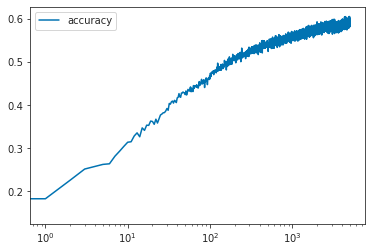

In [26]:
metrics = history.history
plt.semilogx(history.epoch, metrics['accuracy'])
plt.legend(['accuracy'])
plt.show()

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [27]:
test_ds = preprocess_dataset(test_files)
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

25/25 [==============================] - 2s 83ms/step
Test set accuracy: 52%


### Display a confusion matrix

Use a <a href="https://developers.google.com/machine-learning/glossary#confusion-matrix" class="external">confusion matrix</a> to check how well the model did classifying each of the commands in the test set:


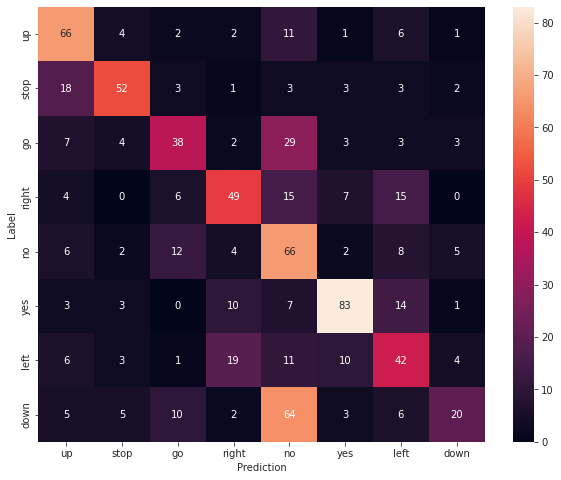

In [28]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

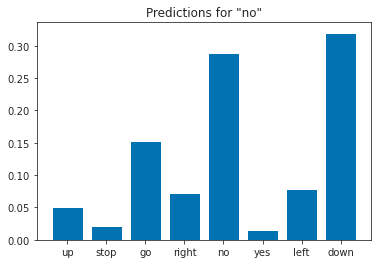

In [29]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'
sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

As the output suggests, your model should have recognized the audio command as "no".

# Processing the model for hls4ml

From this model I will attempt to create an HLS model.

### Configuration Parameters

In [30]:
hls_model_base_filename = "simple_hls"
ap_fixed_length = 32
ap_fixed_int_part = 10
xilix_part = None
real_hw = False
if real_hw:
    xilinx_part = "xc7z007sclg225-1" #Avnet MiniZed
else:
    xilinx_part = "xczu7cg-fbvb900-1-i" #Zynq Ultrascale MPSoCs (Max LUT, FF, DSP)
    #xilinx_part = "xc7a200tfbg484-1" #Artix-7 (Max SLICE, BRAM)

### Model JSON file creation
Creating files for model, weights, input data and output predictions
- To re-run this, you have to restart the kernel, as `model.save_weights` doesn't close the file.

In [31]:
with open(hls_model_base_filename+"_model.json", "w") as json_file:
    json_file.write(model.to_json())
    json_file.close()
    
model.save_weights(hls_model_base_filename+"_weights.h5")

### Test data creation for later experiments

In [32]:
test_samples = ['down/00b01445_nohash_1.wav',
                'go/0a9f9af7_nohash_0.wav',
                'left/00b01445_nohash_0.wav',
                'no/01bb6a2a_nohash_0.wav',
                'right/0ab3b47d_nohash_0.wav',
                'stop/0b40aa8e_nohash_0.wav',
                'up/0ab3b47d_nohash_0.wav',
                'yes/00f0204f_nohash_0.wav']

test_sample_data = []
#append each element
with open(hls_model_base_filename+"_input_data.dat", 'a') as sample_input:
    with open(hls_model_base_filename+"_output_data.dat", 'a') as sample_output:
        for command in test_samples:
            tsd_line = []
            for spectrogram, label in preprocess_dataset([str(data_dir/command)]).batch(1):
                for line1 in spectrogram.numpy():
                    for line2 in line1:
                        for line3 in line2:
                            for num in line3:
                                sample_input.write('{:.8f}'.format(num)+' ')
                prediction = model(spectrogram)
                for num in prediction[0].numpy():
                    tsd_line.append(num)
                    sample_output.write('{:.8f}'.format(num)+' ')
            sample_input.write('\n')
            sample_output.write('\n')
            test_sample_data.append(tsd_line)

# HLS4ML Configuration & Compilation

Some notes on the HLSConfig settings

- Generally, the model is tuned for latency, since the bulk of the trainable parameters are on the Convolution and Dense layers.
- The ReuseFactor value isn't the same for every layer, but hls4ml lowers it to the first lower valid value

In [39]:
config_dict = {
    'KerasJson': "{}_model.json".format(hls_model_base_filename),
    'KerasH5': "{}_weights.h5".format(hls_model_base_filename),
    'InputData': "{}_input_data.dat".format(hls_model_base_filename),
    'OutputPredictions': "{}_output_data.dat".format(hls_model_base_filename),
    'OutputDir': 'speechprojectmodel_{}'.format(hw_strat),
    'ProjectName': 'myspeechproject_{}'.format(hw_strat),
    'XilinxPart': xilinx_part,
    'ClockPeriod': 5,
    'IOType': 'io_stream',
    'HLSConfig' : {
        'Model' : {
            'ReuseFactor': 1,
            'Precision': "ap_fixed<{},{}>".format(ap_fixed_length,ap_fixed_int_part), 
            'Strategy': hw_strategies[hw_strat]['Strategy']
         },
        'LayerType' : {
            'Conv2D' : {
                'ReuseFactor' :  hw_strategies[hw_strat]['ConvReuseFactor'],
                'Strategy'    :  hw_strategies[hw_strat]['Strategy'],
            },
            'Dense'  : {
                'ReuseFactor' :  hw_strategies[hw_strat]['DenseReuseFactor'],
                'Strategy'    :  hw_strategies[hw_strat]['Strategy'],
            },
        },
    }
}

# Instantiate the hls model
tic1 = time.time()
hls_model = hls4ml.converters.keras_to_hls(config_dict)
toc1 = time.time()
print('Conversion time', toc1-tic1)
# Compile Model and Run C Simulation
tic2 = time.time()
_ = hls_model.build(csim=True, synth=True, cosim=True, export=True)
toc2 = time.time()
print('Build time', toc2-tic2, 'or', (toc2-tic2)/3600, 'hours.')

Interpreting Sequential
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 124, 129, 1]], output shape: [None, 124, 129, 1]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 124, 129, 1]], output shape: [None, 124, 129, 1]
Layer name: conv2d, layer type: Conv2D, input shapes: [[None, 124, 129, 1]], output shape: [None, 122, 127, 1]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 122, 127, 1]], output shape: [None, 61, 63, 1]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 61, 63, 1]], output shape: [None, 3843]
Layer name: dense, layer type: Dense, input shapes: [[None, 3843]], output shape: [None, 12]
Layer name: dense_1, layer type: Dense, input shapes: [[None, 12]], output shape: [None, 8]
Creating HLS model
Conversion time 0.5440738201141357
Writing HLS project
Done

****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on

INFO: [XFORM 203-603] Inlining function 'nnet::product::mult<ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0> >::limit' into 'nnet::normalize<nnet::array<ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, nnet::array<ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, config2>' (firmware/nnet_utils/nnet_batchnorm_stream.h:46).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>::operator[]' into 'nnet::compute_output_buffer_2d<nnet::array<ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, nnet::array<ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, config3>' (firmware/nnet_utils/nnet_conv_stream.h:285).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>::operator[]' into 'nnet::dense<nnet::array<ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, nnet::array<ap_fixed<3

INFO: [HLS 200-111] Finished Standard Transforms Time (s): cpu = 00:02:23 ; elapsed = 00:02:35 . Memory (MB): peak = 1099.824 ; gain = 651.035 ; free physical = 5219 ; free virtual = 9268
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, config3_mult>' into 'nnet::conv_2d_cl<nnet::array<ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, nnet::array<ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, config3>' (firmware/nnet_utils/nnet_dense_resource.h:99->firmware/nnet_utils/nnet_dense_resource.h:274->firmware/nnet_utils/nnet_conv_stream.h:279->firmware/nnet_utils/nnet_conv2d_stream.h:85->firmware/nnet_utils/nnet_conv2d_stream.h:103) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::Op_max<ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0> >::operator()' into 'nnet::reduce<ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 2, n

INFO: [HLS 200-489] Unrolling loop 'KernelShiftWidth' (firmware/nnet_utils/nnet_conv_stream.h:188) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, config5>' completely with a factor of 1.
INFO: [HLS 200-489] Unrolling loop 'KernelShiftHeight' (firmware/nnet_utils/nnet_conv_stream.h:190) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, config5>' completely with a factor of 2.
INFO: [HLS 200-489] Unrolling loop 'KernelPushHeight' (firmware/nnet_utils/nnet_conv_stream.h:200) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, config5>' completely with a factor of 2.
INFO: [HLS 200-489] Unrolling loop 'LineBufferShift' (firmware/nnet_utils/nnet_conv_stream.h:229) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, config3>' completely with a factor of 2.
INFO: [HLS 200-489] Unrollin

INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, config7>' into 'nnet::dense_wrapper<ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, config7>' (firmware/nnet_utils/nnet_dense_resource.h:99->firmware/nnet_utils/nnet_dense_resource.h:274->firmware/nnet_utils/nnet_dense_stream.h:24) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, config9>' into 'nnet::dense_wrapper<ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<32, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, config9>' (firmware/nnet_utils/nnet_dense_resource.h:178->firmware/nnet_utils/nnet_dense_resource.h:276->firmware/nnet_utils/nnet_dense_stream.h:24) automatically.
INFO: [XFORM 203-712] Applying dataflow to function 'myspeechproject_absolute', detected/extracted 8 proc

INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:151) in function 'dense_wrapper<ap_fixed,ap_fixed<32,10,5,3,0>,config9>'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:64) in function 'dense_wrapper<ap_fixed,ap_fixed<32,10,5,3,0>,config7>'.
INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 05:48:09 ; elapsed = 05:51:16 . Memory (MB): peak = 9515.832 ; gain = 9067.043 ; free physical = 242 ; free virtual = 1354
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myspeechproject_absolute' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'Block_proc' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 21081.6 seconds; c

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.44 seconds; current allocated memory: 862.086 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_wrapper_ap_fixed_ap_fixed_32_10_5_3_0_config7_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining loop 'ReuseLoop'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 83.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 440.7 seconds; current allocated memory: 960.946 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [B

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_array_ap_fixed_1u_relu_config4_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_array_array_ap_fixed_1u_relu_config4_s'.
INFO: [HLS 200-111]  Elapsed time: 0.96 seconds; current allocated memory: 2.055 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'shift_line_buffer_array_ap_fixed_1u_config5_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_1u_config5_s_line_buffer_Array_V_1_0_0' to 'shift_line_buffer_array_ap_fixed_1u_config5_s_line_bufferdEe' due to the length limit 60
INFO: [RTGEN 206-100] Finished creating RTL model for 'shift_line_buffer_array_

INFO: [RTMG 210-285] Implementing FIFO 'start_for_conv_2d_cl_array_array_ap_fixed_1u_config3_U0_U(start_for_conv_2d_cl_array_array_ap_fixed_1u_config3_U0)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_relu_array_array_ap_fixed_1u_relu_config4_U0_U(start_for_relu_array_array_ap_fixed_1u_relu_config4_U0)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_pooling2d_cl_array_array_ap_fixed_1u_config5_U0_U(start_for_pooling2d_cl_array_array_ap_fixed_1u_config5_U0)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_dense_array_array_ap_fixed_32_10_5_3_0_12u_conffYi_U(start_for_dense_array_array_ap_fixed_32_10_5_3_0_12u_conffYi)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_relu_array_array_ap_fixed_12u_relu_config8_U0_U(start_for_relu_array_array_ap_fixed_12u_relu_config8_U0)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_dense_array_array_ap_fixed_32_10_5_3_0_8u_c

INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/home/simplehls/Desktop/project/speechprojectmodel_absolute/myspeechproject_absolute_prj/solution1/sim/verilog/dense_wrapper_ap_fixed_ap_fixed_32_10_5_3_0_config9_s_outeOg.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module dense_wrapper_ap_fixed_ap_fixed_32_10_5_3_0_config9_s_outeOg_rom
INFO: [VRFC 10-311] analyzing module dense_wrapper_ap_fixed_ap_fixed_32_10_5_3_0_config9_s_outeOg
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/home/simplehls/Desktop/project/speechprojectmodel_absolute/myspeechproject_absolute_prj/solution1/sim/verilog/fifo_w32_d15494_A.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module fifo_w32_d15494_A
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/home/simplehls/Desktop/project/speechprojectmodel_absolute/myspeechproject_absolute_prj/solution1/sim/verilog/AESL_deadlock_report_unit.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module AESL_deadlock_report_uni

Built simulation snapshot myspeechproject_absolute

****** Webtalk v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /home/simplehls/Desktop/project/speechprojectmodel_absolute/myspeechproject_absolute_prj/solution1/sim/verilog/xsim.dir/myspeechproject_absolute/webtalk/xsim_webtalk.tcl -notrace
INFO: [Common 17-186] '/home/simplehls/Desktop/project/speechprojectmodel_absolute/myspeechproject_absolute_prj/solution1/sim/verilog/xsim.dir/myspeechproject_absolute/webtalk/usage_statistics_ext_xsim.xml' has been successfully sent to Xilinx on Fri Aug  5 19:00:22 2022. For additional details about this file, please refer to the WebTalk help file at /tools/Xilinx/Vivado/2019.2/doc/webtalk_introduction.html.
INFO: [Common 17-206] Exiting Webtalk at Fri Aug  5 19:00:22 2022...

****** xsim v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:

////////////////////////////////////////////////////////////////////////////////////
// Inter-Transaction Progress: Completed Transaction / Total Transaction
// Intra-Transaction Progress: Measured Latency / Latency Estimation * 100%
//
// RTL Simulation : "Inter-Transaction Progress" ["Intra-Transaction Progress"] @ "Simulation Time"
////////////////////////////////////////////////////////////////////////////////////
// RTL Simulation : 0 / 8 [0.00%] @ "113000"
// RTL Simulation : 1 / 8 [187.01%] @ "2186718000"
// RTL Simulation : 2 / 8 [0.04%] @ "2187228000"
// RTL Simulation : 3 / 8 [187.01%] @ "4373323000"
// RTL Simulation : 4 / 8 [0.04%] @ "4373833000"
// RTL Simulation : 5 / 8 [187.01%] @ "6559928000"
// RTL Simulation : 6 / 8 [0.04%] @ "6560438000"
// RTL Simulation : 7 / 8 [187.01%] @ "8746533000"
// RTL Simulation : 8 / 8 [100.00%] @ "8747043000"
////////////////////////////////////////////////////////////////////////////////////
$finish called at time : 8747062500 ps : File 

Retrieving processing report, as well as data from C Simulation and C/RTL Cosimulation

In [40]:
report_filename = config_dict.get('OutputDir')+'/vivado_hls.log'
if pathlib.Path(report_filename).exists() :
    with open(report_filename, "r") as report_file:
        print('Vivado report found')
else :
    print("Vivado report file not found")
    print(report_filename)

csim_results = []
csim_filename = f"{config_dict.get('OutputDir')}/tb_data/csim_results.log"
if pathlib.Path(csim_filename).exists() :
    with open(csim_filename, "r") as results_file:
        for line in results_file:
            tsr_line = []
            for str_num in line.split():
                tsr_line.append(float(str_num))
            csim_results.append(tsr_line)
else :
    print("C Simulation results file not found")
    print(csim_filename)
# if csim_results is empty, fill it with NaN in the shape we expect later
if not csim_results:
    csim_results = np.empty(np.shape(test_sample_data))
    csim_results[:] = np.nan

cosim_results = []
cosim_filename = f"{config_dict.get('OutputDir')}/tb_data/rtl_cosim_results.log"
if pathlib.Path(cosim_filename).exists() :
    with open(cosim_filename, "r") as results_file:
        for line in results_file:
            tsr_line = []
            for str_num in line.split():
                tsr_line.append(float(str_num))
            cosim_results.append(tsr_line)
else :
    print("C/RTL Co-Simulation results file not found")
    print(cosim_filename)
# if cosim_results is empty, fill it with NaN in the shape we expect later
if not cosim_results:
    cosim_results = np.empty(np.shape(test_sample_data))
    cosim_results[:] = np.nan

Vivado report found


# Resulting Statistics

Below are plotted the outputs for:
- Inference from Keras
- Output from Vivado

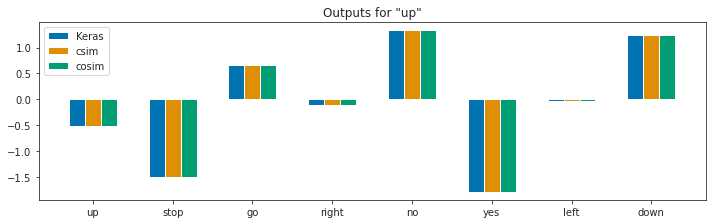

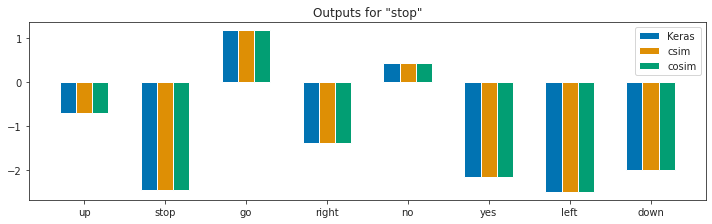

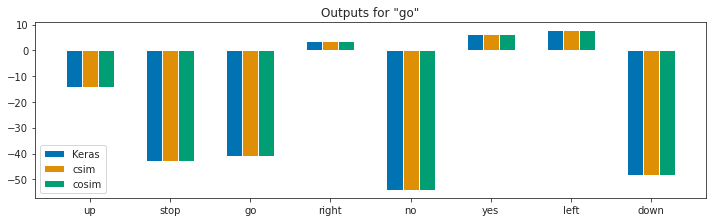

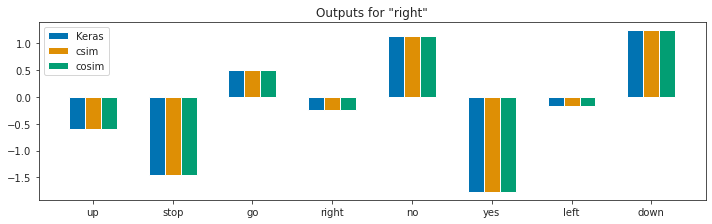

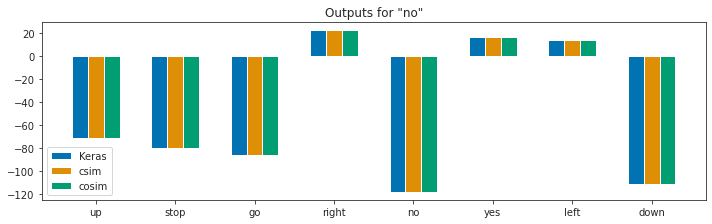

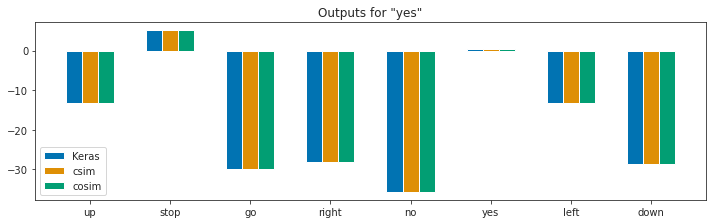

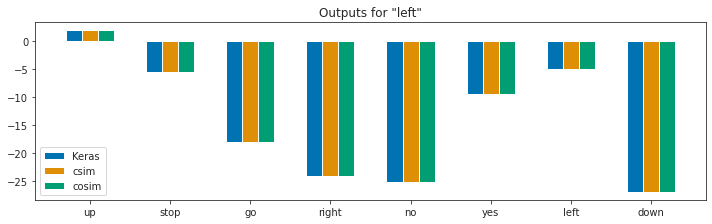

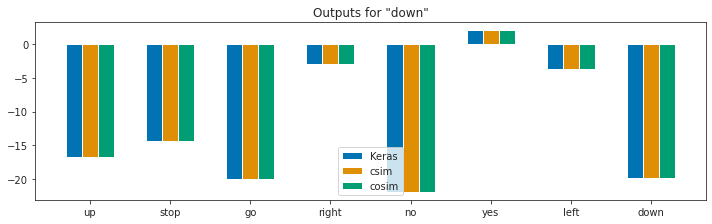

In [41]:
for test_index in range(num_labels):
    x = np.arange(num_labels)
    width = 0.2
    figb, axb = plt.subplots(figsize=(10, 3))
    rects1 = axb.bar(x - width, test_sample_data[test_index][:], width, label='Keras')
    rects2 = axb.bar(x, csim_results[test_index][:], width, label='csim')
    rects3 = axb.bar(x + width, cosim_results[test_index][:], width, label='cosim')
    axb.set_xticks(x)
    axb.set_xticklabels(commands)
    axb.legend()
    figb.tight_layout()
    axb.set_title(f'Outputs for "{commands[test_index]}"')
    plt.show()

At this point, it is evident that for each input the maximum value of the predicted output from the Keras model corresponds to the output of the simulated HLS design, although the HLS Design's output is quantized differently.

Below, I compute some mean deviations based on the difference between sample data and the normalized results.

In [42]:
def print_deviations(original, deviated):
    mean_dev = 0
    mean_dev_correct = 0
    mean_dev_wrong = 0
    mean_dev_by_label = np.zeros(num_labels)
    for i in range(num_labels):
        for j in range(num_labels):
            deviation = abs(original[i][j] - deviated[i][j])
            mean_dev += deviation
            mean_dev_by_label[j] += deviation
            if i == j:
                mean_dev_correct += deviation
            else:
                mean_dev_wrong += deviation

    mean_dev /= math.pow(num_labels,2)
    mean_dev_correct /= num_labels
    mean_dev_wrong /= (math.pow(num_labels,2) - num_labels)
    for i in range(num_labels):
        mean_dev_by_label[i] /= num_labels

    print('Average deviation between all results:', mean_dev)
    print('Average deviation between correct labels:', mean_dev_correct)
    print('Average deviation between wrong labels:', mean_dev_wrong)
    print('Average deviation per label:')
    for i in range(num_labels):
        print(f' -{commands[i]}\t: {str(mean_dev_by_label[i])}')
    return mean_dev

print('=== Statistics between Keras and C Simulation===')
_ = print_deviations(test_sample_data, csim_results)
print('=== Statistics between Keras and C/RTL Co-Simulation===')
_ = print_deviations(test_sample_data, cosim_results)

=== Statistics between Keras and C Simulation===
Average deviation between all results: 0.0006556063412420007
Average deviation between correct labels: 0.0007654922294622821
Average deviation between wrong labels: 0.0006399083572105319
Average deviation per label:
 -up	: 0.0005368475108140092
 -stop	: 0.0005717105627062458
 -go	: 0.0010170231704704422
 -right	: 0.0003561227298976323
 -no	: 0.0012388737320909102
 -yes	: 0.00017110141849502325
 -left	: 0.0002446903175055892
 -down	: 0.0011084812879561534
=== Statistics between Keras and C/RTL Co-Simulation===
Average deviation between all results: 0.0006556063412420007
Average deviation between correct labels: 0.0007654922294622821
Average deviation between wrong labels: 0.0006399083572105319
Average deviation per label:
 -up	: 0.0005368475108140092
 -stop	: 0.0005717105627062458
 -go	: 0.0010170231704704422
 -right	: 0.0003561227298976323
 -no	: 0.0012388737320909102
 -yes	: 0.00017110141849502325
 -left	: 0.0002446903175055892
 -down	: